In [1]:
import pandas as pd
import numpy as np
import psycopg2

# 1. Extraction, Transform and EDA

In [2]:
df_enquiries = pd.read_csv('enquiries.csv')
df_listings = pd.read_csv('listings.csv')
df_searches = pd.read_csv('searches.csv')
df_users = pd.read_csv('users.csv')

## 1.1 Enquiries

In [3]:
# Retrieve Random Samples
df_enquiries.sample(5)

,enquiry_date,enquiry_id,listing_id,user_id
3477,2018-07-26 22:06:34,3478,listing_2564,u1681
1184,2018-07-07 20:37:39,1185,listing_1966,u2075
3140,2018-07-23 18:05:02,3141,listing_205,u543
2202,2018-07-15 17:13:17,2203,listing_89,u2278
2042,2018-07-14 17:35:17,2043,listing_2718,u2105


In [4]:
# Check DataFrame Dimensions
df_enquiries.shape

(4058, 4)

In [5]:
# Assuming Enquiry_ID is the Unique Identifier aside from the Date, check for duplicates
df_enquiries['enquiry_id'].nunique()

4058

In [6]:
# Check for any null values
df_enquiries.isna().sum()

enquiry_date    0
enquiry_id      0
listing_id      0
user_id         0
dtype: int64

In [7]:
# Check for any empty values for both listing_id and user_id
df_enquiries[df_enquiries['listing_id'] == ''].T.count(), df_enquiries[df_enquiries['user_id'] == ''].T.count()

(Series([], dtype: int64), Series([], dtype: int64))

## 1.2 Listings

In [8]:
# Retrieve Random Samples
df_listings.sample(5)

,location,listing_type,listing_id
2700,dtdistrict16,rent,listing_658
2629,dtdistrict27,rent,listing_594
2403,dtdistrict03,room,listing_390
1912,dtdistrict03,rent,listing_272
494,dtdistrict25,rent,listing_1443


In [9]:
# Check DataFrame Dimensions
df_listings.shape

(3079, 3)

In [10]:
# Assuming Listing_ID is the Unique Identifier, check for duplicates
df_listings['listing_id'].nunique()

3079

In [11]:
# Check for any null values
df_listings.isna().sum()

location        0
listing_type    0
listing_id      0
dtype: int64

In [12]:
# Check for any empty values for both listing_id and user_id
df_listings[df_listings['location'] == ''].T.count(), df_listings[df_listings['listing_type'] == ''].T.count()

(Series([], dtype: int64), Series([], dtype: int64))

## 1.3 Searches

In [13]:
# Retrieve Random Samples
df_searches.sample(5)

,search_time,search_id,listing_type,property_type,search_location,search_price_min,search_price_max,platform,user_id
6217,2018-07-08 14:54:11,6218,sale,condo,"dtdistrict01,dtdistrict02,dtdistrict06,dtdistr...",100000.0,1200000.0,web,u2125
13570,2018-07-17 3:13:29,13571,rent,"condo,landed","dtdistrict15,dtdistrict16",4000.0,5500.0,web,u776
20743,2018-07-26 1:59:33,20744,sale,condo,dtdistrict23,800000.0,1200000.0,web,u867
11881,2018-07-15 5:20:01,11882,sale,condo,dtdistrict11,1000000.0,2000000.0,web,u735
5672,2018-07-07 20:34:03,5673,rent,NaN,"dtdistrict03,dtdistrict09,dtdistrict10,dtdistr...",4000.0,6000.0,web,u2171


In [14]:
# Check DataFrame Dimensions
df_searches.shape

(25332, 9)

In [15]:
# Assuming Search_ID is the Unique Identifier aside from the date, check for duplicates
df_searches['search_id'].nunique()

25332

In [16]:
# Check for any null values
df_searches.isna().sum()

search_time             0
search_id               0
listing_type            0
property_type        8084
search_location         0
search_price_min    11906
search_price_max     1548
platform                0
user_id                 0
dtype: int64

In [17]:
# Check the Value Counts for property_type
df_searches['property_type'].value_counts(dropna=False)

condo               9518
NaN                 8084
hdb                 3092
landed              1940
condo,landed        1607
condo,hdb            858
condo,hdb,landed     184
hdb,landed            27
all                   18
condo,landed,hdb       4
Name: property_type, dtype: int64

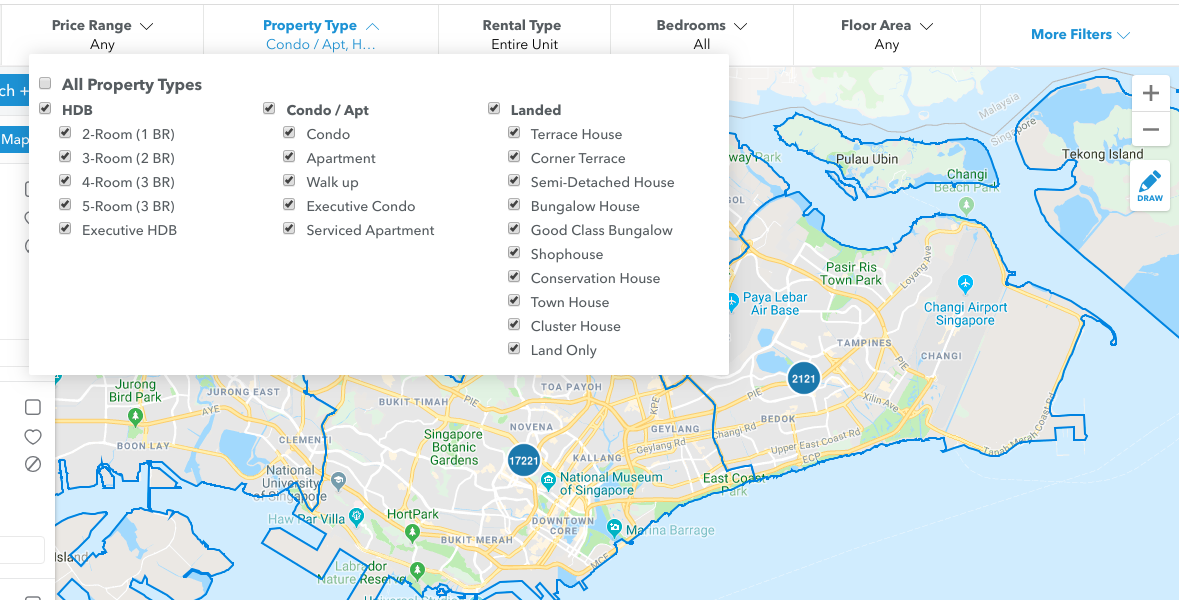

99.co website have the following options for search:
- HDB
- Condo / Apt
- Landed
- Or any or all combinations of the 3 above

Make the following assumptions for valid data:
- condo (keep)
- NaN -> condo, hdb, landed
- hdb (keep)
- landed (keep)
- condo, landed (keep)
- condo, hdb (keep)
- condo, hdb, landed -> (keep)
- hdb, landed (keep)
- all -> condo, hdb, landed
- condo, landed, hdb -> condo, hdb, landed

In [18]:
# Replace the values based on the assumptions above
df_searches['property_type'].replace(to_replace=np.NaN, value='condo,hdb,landed', inplace=True)
df_searches['property_type'].replace(to_replace='all', value='condo,hdb,landed', inplace=True)
df_searches['property_type'].replace(to_replace='condo,landed,hdb', value='condo,hdb,landed', inplace=True)

In [19]:
# Check the values again
df_searches['property_type'].value_counts(dropna=False)

condo               9518
condo,hdb,landed    8290
hdb                 3092
landed              1940
condo,landed        1607
condo,hdb            858
hdb,landed            27
Name: property_type, dtype: int64

In [20]:
df_searches.columns

Index(['search_time', 'search_id', 'listing_type', 'property_type',
       'search_location', 'search_price_min', 'search_price_max', 'platform',
       'user_id'],
      dtype='object')

In [21]:
# Split the property_type column by ',' into multiple columns
df_searches_property = df_searches['property_type'].str.split(',', expand=True)
df_searches_property.columns = ['property_type_{}'.format(number) for number in range(3)]

In [22]:
# Join the expanded property type columns to the dataframe and drop the original column (property_type)
df_searches = df_searches.join(df_searches_property)
df_searches.drop(axis=1, columns=['property_type'], inplace=True)

In [23]:
# Split the search_location column by ',' into multiple columns
df_searches_location = df_searches['search_location'].str.split(',', expand=True)
df_searches_location.columns = ['search_location_{}'.format(number) for number in range(len(df_searches_location.columns))]

In [24]:
# Join the expanded property type columns to the dataframe and drop the original column (property_type)
df_searches = df_searches.join(df_searches_location)
df_searches.drop(axis=1, columns=['search_location'], inplace=True)

In [25]:
# Check for Null values for the minimum search price and compare with the overall count
df_searches['search_price_min'].isna().sum(), df_searches['search_price_min'].count()

(11906, 13426)

In [26]:
# User not entering any value for the minimum search implies that 0 is the minimum
df_searches['search_price_min'].replace(to_replace=np.NaN, value=0, inplace=True)

In [27]:
# Check for Null values for the maximum search price and compare with the overall count
df_searches['search_price_max'].isna().sum(), df_searches['search_price_max'].count()

(1548, 23784)

In [28]:
# User not entering any value for the maximum search implies that the highest prices of available listing
# will be the limit
# However, there is no price data from listing, so we will go with the max value possible in the search data
df_searches['search_price_max'].replace(to_replace=np.NaN, value=df_searches['search_price_max'].max(), inplace=True)

In [29]:
# Check for any empty values for other fields
df_searches[df_searches['listing_type'] == ''].T.count(), df_searches[df_searches['platform'] == ''].T.count(), df_searches[df_searches['user_id'] == ''].T.count(),

(Series([], dtype: int64), Series([], dtype: int64), Series([], dtype: int64))

In [30]:
df_searches.sample(5)

,search_time,search_id,listing_type,search_price_min,search_price_max,platform,user_id,property_type_0,property_type_1,property_type_2,...,search_location_14,search_location_15,search_location_16,search_location_17,search_location_18,search_location_19,search_location_20,search_location_21,search_location_22,search_location_23
14181,2018-07-17 14:36:11,14182,rent,0.0,3500.0,web,u843,condo,None,None,...,None,None,None,None,None,None,None,None,None,None
18319,2018-07-23 2:18:05,18320,rent,0.0,3500.0,web,u1057,condo,landed,None,...,None,None,None,None,None,None,None,None,None,None
14333,2018-07-17 21:31:28,14334,rent,1000.0,20000000.0,web,u692,condo,None,None,...,None,None,None,None,None,None,None,None,None,None
557,2018-07-01 9:45:25,558,sale,0.0,1800000.0,web,u225,condo,None,None,...,None,None,None,None,None,None,None,None,None,None
801,2018-07-01 13:02:51,802,rent,0.0,2000.0,web,u187,condo,None,None,...,None,None,None,None,None,None,None,None,None,None


In [31]:
df_searches.columns

Index(['search_time', 'search_id', 'listing_type', 'search_price_min',
       'search_price_max', 'platform', 'user_id', 'property_type_0',
       'property_type_1', 'property_type_2', 'search_location_0',
       'search_location_1', 'search_location_2', 'search_location_3',
       'search_location_4', 'search_location_5', 'search_location_6',
       'search_location_7', 'search_location_8', 'search_location_9',
       'search_location_10', 'search_location_11', 'search_location_12',
       'search_location_13', 'search_location_14', 'search_location_15',
       'search_location_16', 'search_location_17', 'search_location_18',
       'search_location_19', 'search_location_20', 'search_location_21',
       'search_location_22', 'search_location_23'],
      dtype='object')

In [50]:
df_searches.sample(5)

,search_time,search_id,listing_type,search_price_min,search_price_max,platform,user_id,property_type,search_loc
64683,2018-07-17 9:30:25,14020,room,0.0,700.0,web,u517,landed,dtdistrict12
67602,2018-07-21 1:09:32,16939,room,500.0,1000.0,web,u1820,landed,dtdistrict27
703939,2018-07-25 2:13:10,19976,rent,0.0,1500.0,web,u1914,condo,dtdistrict12
8817,2018-07-11 9:49:50,8818,sale,0.0,1500000.0,web,u263,condo,dtdistrict23
100839,2018-07-31 7:12:05,24844,sale,700000.0,1200000.0,web,u295,condo,dtdistrict03


In [33]:
# Melt the DataFrame to unpivot (target property type first)
df_searches = df_searches.melt(
    id_vars=['search_time', 'search_id', 'listing_type', 'search_price_min',
           'search_price_max', 'platform', 'user_id', 'search_location_0',
           'search_location_1', 'search_location_2', 'search_location_3',
           'search_location_4', 'search_location_5', 'search_location_6',
           'search_location_7', 'search_location_8', 'search_location_9',
           'search_location_10', 'search_location_11', 'search_location_12',
           'search_location_13', 'search_location_14', 'search_location_15',
           'search_location_16', 'search_location_17', 'search_location_18',
           'search_location_19', 'search_location_20', 'search_location_21',
           'search_location_22', 'search_location_23'], 
    value_vars=['property_type_0', 'property_type_1', 'property_type_2'],
    var_name='property_var',
    value_name='property_type')

In [34]:
# Melt the DataFrame to unpivot (target property type first)
df_searches = df_searches.melt(
    id_vars=['search_time', 'search_id', 'listing_type', 'search_price_min',
           'search_price_max', 'platform', 'user_id', 'property_var', 'property_type'], 
    value_vars=['search_location_0',
           'search_location_1', 'search_location_2', 'search_location_3',
           'search_location_4', 'search_location_5', 'search_location_6',
           'search_location_7', 'search_location_8', 'search_location_9',
           'search_location_10', 'search_location_11', 'search_location_12',
           'search_location_13', 'search_location_14', 'search_location_15',
           'search_location_16', 'search_location_17', 'search_location_18',
           'search_location_19', 'search_location_20', 'search_location_21',
           'search_location_22', 'search_location_23'],
    var_name='search_loc_var',
    value_name='search_loc')

In [35]:
# Drop all None Columns from both property_type and search_loc
df_searches.dropna(inplace=True)

In [36]:
# Remove columns property_var and search_loc_var
df_searches.drop(axis=1, columns=['property_var', 'search_loc_var'], inplace=True)

In [37]:
# Retrieve sample of the new dataframe
df_searches.sample(5)

,search_time,search_id,listing_type,search_price_min,search_price_max,platform,user_id,property_type,search_loc
324837,2018-07-26 5:34:28,20854,rent,7000.0,14000.0,web,u890,condo,dtdistrict10
152812,2018-07-01 13:24:36,821,rent,0.0,4000.0,web,u428,condo,dtdistrict03
391087,2018-07-14 11:32:35,11108,sale,400000.0,600000.0,web,u216,condo,dtdistrict06
82050,2018-07-08 10:55:29,6055,room,1000.0,20000000.0,web,u1995,condo,dtdistrict14
807115,2018-07-27 9:19:40,21824,rent,1500.0,20000000.0,web,u269,hdb,dtdistrict11


In [38]:
# Check the final dimension
df_searches.shape

(148487, 9)

## 1.4 Users

In [39]:
# Retrieve Random Samples
df_users.sample(5)

,user_id,user_type
522,u523,anon
914,u915,anon
854,u855,anon
1692,u1693,registered
1503,u1504,anon


In [40]:
# Check DataFrame Dimensions
df_users.shape

(2287, 2)

In [41]:
# Assuming User_ID is the Unique Identifier, check for duplicates
df_users['user_id'].nunique()

2287

In [42]:
# Check for any null values
df_users.isna().sum()

user_id      0
user_type    0
dtype: int64

In [43]:
# Check for any empty values for other fields
df_users[df_users['user_type'] == ''].T.count()

Series([], dtype: int64)

# 2. Load Data to DB

In [44]:
# PostgreSQL Parameters
DBNAME = '99co'
USERNAME = 'postgres'
PASSWORD = 'postgres'

HOST = 'localhost'
PORT = '5432'

In [45]:
# Create tables in local PostgreSQL database 99co
try:
    conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
    cur = conn.cursor()
    
    try:
        cur.execute("CREATE TABLE users (user_id varchar PRIMARY KEY, user_type varchar);")
        conn.commit()
        print('user table succesfully created in the database')
    except:
        print("Unable to create user table in the database")
        
    try:
        cur.execute("CREATE TABLE listings (listing_id varchar PRIMARY KEY, listing_type varchar, location varchar);")
        conn.commit()
        print('listings table succesfully created in the database')
    except:
        print("Unable to create listing table in the database")
    
    try:
        cur.execute("CREATE TABLE enquiries (enquiry_id serial PRIMARY KEY, enquiry_date date, listing_id varchar, user_id varchar);")
        conn.commit()
        print('enquiries table succesfully created in the database')
    except:
        print("Unable to create enquiries table in the database")
        
    try:
        cur.execute("CREATE TABLE search (search_id int, search_time date, listing_type varchar, search_price_min bigint, search_price_max bigint, platform varchar, user_id varchar, property_type varchar, search_loc varchar);")
        conn.commit()
        print('search table succesfully created in the database')
    except:
        print("Unable to create search table in the database")
        
    conn.close()
    cur.close()
except:
    print("Unable to connect to the database") 

user table succesfully created in the database
listings table succesfully created in the database
enquiries table succesfully created in the database
search table succesfully created in the database


In [46]:
# Insert Users Data
try:
    conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
    cur = conn.cursor()
    
    try:
        insert_query = """ INSERT INTO users (user_id, user_type) VALUES (%s,%s)"""   
        for index, row in df_users.iterrows():
            record = (row['user_id'], row['user_type'])
            cur.execute(insert_query, record)
            conn.commit()
        
        print('Records successfully inserted in user table')
    except:
        print("Error inserting records in user table")
        
    conn.close()
    cur.close()
except:
    print("Unable to connect to the database") 

Records successfully inserted in user table


In [47]:
# Insert Listings Data
try:
    conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
    cur = conn.cursor()
    
    try:
        insert_query = """ INSERT INTO listings (listing_id, listing_type, location) VALUES (%s,%s,%s)"""   
        for index, row in df_listings.iterrows():
            record = (row['listing_id'], row['listing_type'], row['location'])
            cur.execute(insert_query, record)
            conn.commit()
        
        print('Records successfully inserted in listings table')
    except:
        print("Error inserting records in listings table")
        
    conn.close()
    cur.close()
except:
    print("Unable to connect to the database") 

Records successfully inserted in listings table


In [48]:
# Insert Enquiries Data
try:
    conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
    cur = conn.cursor()
    
    try:
        insert_query = """ INSERT INTO enquiries (enquiry_id, enquiry_date, listing_id, user_id) VALUES (%s,%s,%s,%s)"""   
        for index, row in df_enquiries.iterrows():
            record = (row['enquiry_id'], row['enquiry_date'], row['listing_id'], row['user_id'])
            cur.execute(insert_query, record)
            conn.commit()
        
        print('Records successfully inserted in enquiries table')
    except:
        print("Error inserting records in enquiries table")
        
    conn.close()
    cur.close()
except:
    print("Unable to connect to the database") 

Records successfully inserted in enquiries table


In [49]:
# Insert Search Data
try:
    conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
    cur = conn.cursor()
    
    try:
        insert_query = """ INSERT INTO search (search_id, search_time, listing_type, search_price_min, search_price_max, platform, user_id, property_type, search_loc) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)"""   
        for index, row in df_searches.iterrows():
            record = (row['search_id'], row['search_time'], row['listing_type'], row['search_price_min'], row['search_price_max'], row['platform'], row['user_id'], row['property_type'], row['search_loc'])
            cur.execute(insert_query, record)
            conn.commit()
        
        print('Records successfully inserted in search table')
    except:
        print("Error inserting records in search table")
        
    conn.close()
    cur.close()
except:
    print("Unable to connect to the database") 

Records successfully inserted in search table
